In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Data

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read File

In [ ]:
# Specify the file path within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/hmnist_28_28_RGB.csv'  # Replace with your actual file path

# Read the file using Pandas (assuming it's a CSV file)
df = pd.read_csv(file_path)

# Data Preprocessing

Take out the label

In [ ]:
y = df['label']
x = df.drop(columns = ['label'])

In [ ]:
print(x.shape)

(10015, 2352)


Oversample to handle class imbalance

In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler()
#x,y  = oversample.fit_resample(x,y)

Specify Labels

In [ ]:
print(y.nunique())

7


In [ ]:
print(y.value_counts())
#nv       6705 benign
#mel      1113 malignant
#bkl      1099 benign
#bcc       514 malignant
#akiec     327 malignant
#vasc      142 benign
#df        115 benign

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


Replace 4, 2, 5, 3 with benign (0), and rest with malignant (1)

In [ ]:
# Replace values 1, 6, 0 with 1
y.replace({1: 1, 6: 1, 0: 1}, inplace=True)

# Replace values 4, 2, 5, and 3 with 0
y.replace({4: 0, 2: 0, 5: 0, 3: 0}, inplace=True)

In [ ]:
print(y.value_counts())
# benign 8061
# malignant 1954

0    8061
1    1954
Name: label, dtype: int64


Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
print(y.value_counts())

0    8061
1    8061
Name: label, dtype: int64


Reshape data

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (16122, 28, 28, 3)


Convert Shape

In [ ]:
from scipy.ndimage import zoom

images = x

# Define the desired size (224x224)
desired_size = (72, 72)

# Upscale the images using interpolation
upscaled_images = np.zeros((images.shape[0],) + desired_size + (3,))
for i in range(images.shape[0]):
    for channel in range(3):
        upscaled_images[i, :, :, channel] = zoom(images[i, :, :, channel],
                                                 (desired_size[0] / images.shape[1], desired_size[1] / images.shape[2]))
print(upscaled_images.shape)

(16122, 72, 72, 3)


In [ ]:
x = upscaled_images
print(x.shape)

(16122, 72, 72, 3)


Standardization

In [ ]:
x = (x-np.mean(x))/np.std(x)

Train-Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
print(Y_train.value_counts())
print(Y_test.value_counts())

1    6451
0    6446
Name: label, dtype: int64
0    1615
1    1610
Name: label, dtype: int64


# Ensemble Model Training

In [ ]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Average

model_1 = load_model('/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/best_model_vgg16.h5')
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='vgg16')

model_2 = load_model('/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/best_model_squeezenet.h5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='squeezenet')

model_3 = load_model('/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/best_model_resnet50.h5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='resnet50')

model_4 = load_model('/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/best_model_xception.h5')
model_4 = Model(inputs=model_4.inputs,
                outputs=model_4.outputs,
                name='xception')




Average Ensemble

In [ ]:
models = [model_1, model_2, model_3, model_4]

model_input = Input(shape=(72, 72, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [ ]:
ensemble_model.summary()

Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 72, 72, 3)]          0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 1)                    1485612   ['input_1[0][0]']             
                                                          9                                       
                                                                                                  
 squeezenet (Functional)     (None, 1)                    735937    ['input_1[0][0]']             
                                                                                                  
 resnet50 (Functional)       (None, 1)                    2372915   ['input_1[0][0]']      

In [ ]:
ensemble_model.compile(
    optimizer='adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_ensemble_model.keras',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

In [ ]:
history = ensemble_model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 30,
                    callbacks=[callback])

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.0266 - accuracy: 0.9986
Epoch 1: saving model to best_ensemble_model.keras
81/81 [==============================] - 86s 722ms/step - loss: 0.0266 - accuracy: 0.9986 - val_loss: 0.1366 - val_accuracy: 0.9488
Epoch 2/30
81/81 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9990
Epoch 2: saving model to best_ensemble_model.keras
81/81 [==============================] - 53s 658ms/step - loss: 0.0217 - accuracy: 0.9990 - val_loss: 0.1561 - val_accuracy: 0.9384
Epoch 3/30
81/81 [==============================] - ETA: 0s - loss: 0.0242 - accuracy: 0.9991
Epoch 3: saving model to best_ensemble_model.keras
81/81 [==============================] - 44s 546ms/step - loss: 0.0242 - accuracy: 0.9991 - val_loss: 0.1679 - val_accuracy: 0.9260
Epoch 4/30
81/81 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9991
Epoch 4: saving model to best_ensemble_model.keras
81/81 [=================

# Plot Model Progression

Accuracy (training vs validation dataset)

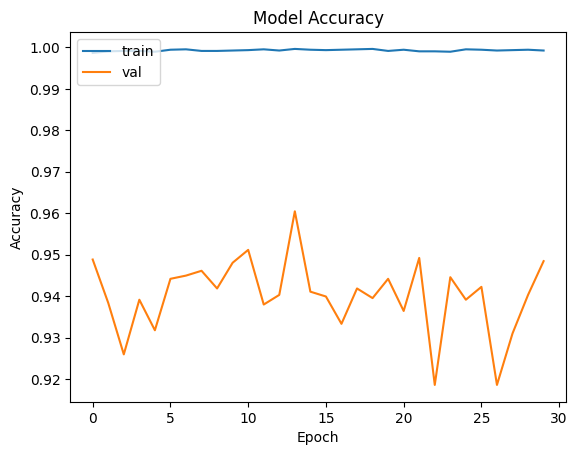

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

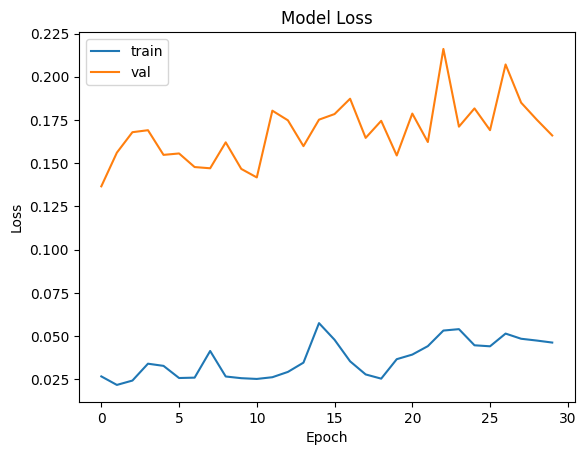

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load best model weights

In [ ]:
#ensemble_model.load_weights('best_ensemble_model.keras')

KeyboardInterrupt: ignored

Print model weights

In [ ]:
'''
# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_ensemble_model.keras')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_avg_ensemble_model.keras')
# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())
            '''

'\n# Load your pre-trained model (replace \'model.h5\' with your model\'s filename)\nbest_model = tf.keras.models.load_model(\'best_ensemble_model.keras\')\n# Define the path where you want to save the model\nmodel_save_path = \'/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/\'\n\n# Save the best model to Google Drive\nbest_model.save(model_save_path + \'best_avg_ensemble_model.keras\')\n# Get the list of all layers in the model\nall_layers = best_model.layers\n\n# Loop through the layers and print their weights if they have any\nfor layer in all_layers:\n    if layer.weights:\n        print(f"Layer: {layer.name}")\n        for weight in layer.weights:\n            print(f"  {weight.name}:")\n            print(weight.numpy())\n            '

# Model Testing

In [ ]:
#loss, acc = model.evaluate(X_test, Y_test, verbose=2)

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = ensemble_model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

101/101 [==============================] - 14s 85ms/step


In [ ]:
threshold = 0.7
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [ ]:
print(y_pred_labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[1522   93]
 [  29 1581]]


In [ ]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.98      0.94      0.96      1615
   malignant       0.94      0.98      0.96      1610

    accuracy                           0.96      3225
   macro avg       0.96      0.96      0.96      3225
weighted avg       0.96      0.96      0.96      3225



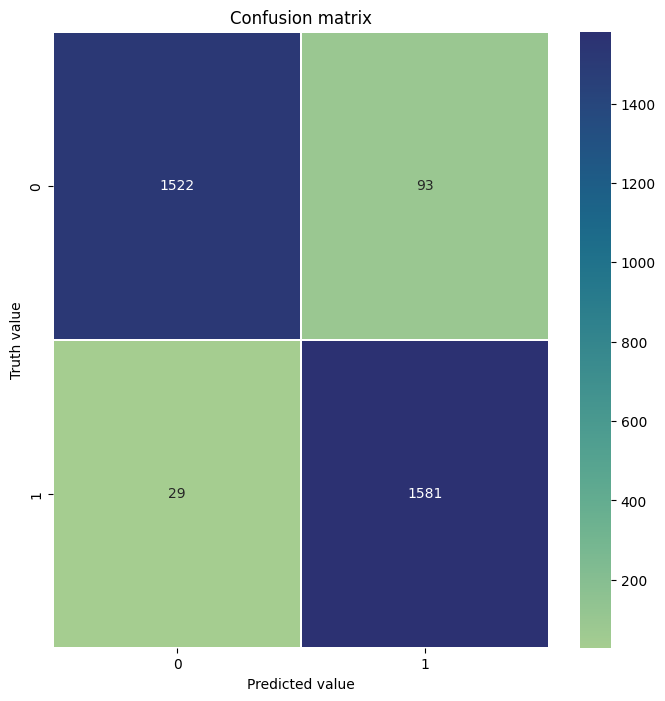

In [ ]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.96
Precision: 0.94
Recall: 0.98
F1-score: 0.96


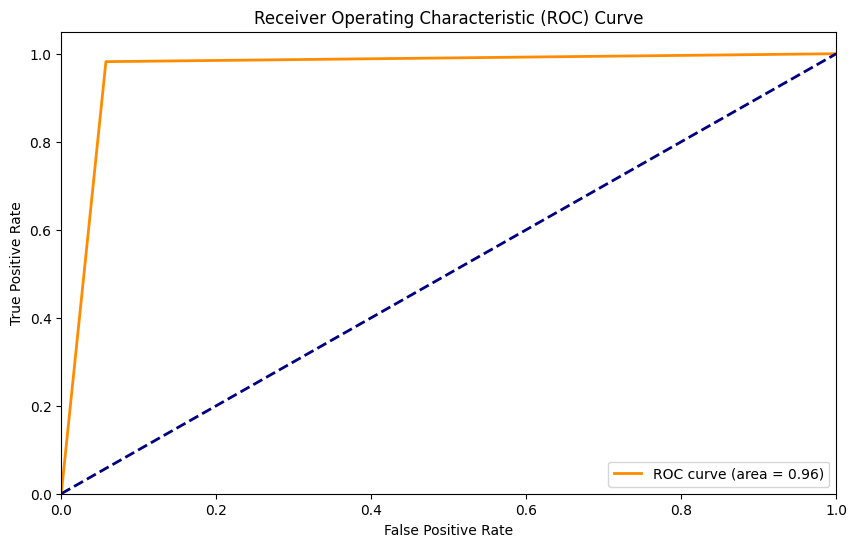

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()